## Over-sampling Method Comparison

We will determine if the different over-sampling algorithms discussed in this section improve the performance of Random Forests on different datasets with imbalanced classes.

In [7]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets

from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [8]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1'),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2'),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear')),
}

In [9]:
datasets_ls = [

    'ozone_level'
]

In [10]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

ozone_level
Counter({np.int64(-1): 2463, np.int64(1): 73})



In [11]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(average_precision_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(average_precision_score(y_test, pred[:, 1])))

    return average_precision_score(y_test, pred[:, 1])

In [12]:
# to save the results
results_dict = {}
shapes_dict = {}

for dataset in datasets_ls:

    results_dict[dataset] = {}
    shapes_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,
    data.target,
    test_size=0.3,
    random_state=0)

    # as some oversampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    roc = run_randomForests(X_train, X_test, y_train, y_test)

    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)

    print()

    for oversampler in oversampler_dict.keys():

        print(oversampler)

        # resample
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)

        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)

        #store results
        results_dict[dataset][oversampler] = roc
        shapes_dict[dataset][oversampler] = len(X_resampled)
        print()

    print()


ozone_level
Train set
Random Forests roc-auc: 0.5131288752408608
Test set
Random Forests roc-auc: 0.1183264608817865

random
Train set
Random Forests roc-auc: 0.9430356218331477
Test set
Random Forests roc-auc: 0.14623534250338768

smote
Train set
Random Forests roc-auc: 0.9549743629405494
Test set
Random Forests roc-auc: 0.16056920562913196

adasyn
Train set
Random Forests roc-auc: 0.9482791378338187
Test set
Random Forests roc-auc: 0.14128236421585644

border1
Train set
Random Forests roc-auc: 0.9824343073053708
Test set
Random Forests roc-auc: 0.1621645576721059

border2
Train set
Random Forests roc-auc: 0.978113488057491
Test set
Random Forests roc-auc: 0.14233157620342482

svm
Train set
Random Forests roc-auc: 0.9820373764572008
Test set
Random Forests roc-auc: 0.15746946177027896




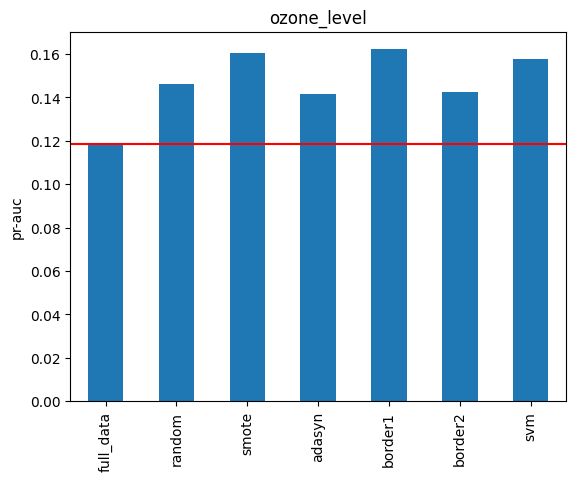

In [13]:
for dataset in datasets_ls:

    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('pr-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

**Different over-sampling techniques work better in different datasets.**

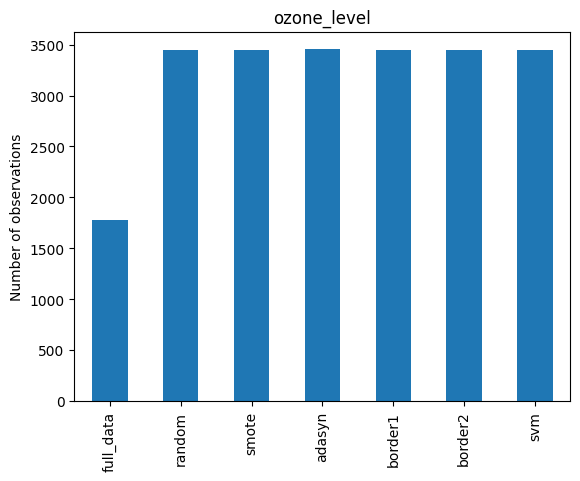

In [15]:
for dataset in datasets_ls:

    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()